In [1]:
import os
import sqlite3
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

# Last.fm Dataset Visualizations

## Introduction

For this project, we will be visualizing the [Last.fm dataset](http://millionsongdataset.com/lastfm/) that can be found as part of the [Million Songs Dataset](http://millionsongdataset.com)(MSD). The Last.fm dataset was released on October 20, 2011. The dataset contains information on the tags found on different tracks as well as the similarity measurements between different tracks from the [last.fm](https://www.last.fm/).


## Data Parsing

The data can be downloaded in two forms: as a raw JSON file or as an SQLite database. I decided to work with the SQLite database because of the smaller size as well as the ease of processing data. There were two provided databases: one database, lastfm_tags.db, contained information on the tags of tracks, and the other database, lastfm_similars contained information on the similarity measures between tracks. We will be working with the lastfm_tags database for this project. Because of the size of the databases, we do not include the database in this repository.

The lastfm_tags database contained the following three tables with corresponding schemas:

```
1. tags (tag TEXT)

2. tid_tag (tid INT, tag INT, val FLOAT)

3. tids (tid TEXT)
```

Unfortunately, the MSD website decided to provide a python script of some sample queries with comments instead of a description of the tables. The script implicitly explained why the `tags` table has a `tag` column composed of strings while the `tid_tag` table contained a `tag` column containing integers: each `tag` number in the `tid_tag` table matches the `tag` string in the corresponding row of the `tags` table. The same relationship applies to the `tid` columns in both the `tids` table and the `tid_tag` table. For clarity, I copied over the tables into a new database `lastfm` and explicitly initialized a column for both the `tags` table and the `tids` table to contain the row number. The resulting table schemas are as follows:

```
1.
    tags (tag_id INT PRIMARY KEY,
          tag TEXT)
```
  - `tag_id` is the unique identifier of a tag.
  - `tag` contains the tag label that you would find on last.fm.


```
2.
    tid_tag (tid INT,
             tag INT,
             val FLOAT,
             FOREIGN KEY(tid) REFERENCES tids(tid_id),
             FOREIGN KEY(tag) REFERENCES tags(tag_id))
```
  - `tid` is the unique number that identifies a track.
  - `tag` is the unique number that identifies a tag.
  - `val` is an unknown value that we will explore in this project.

```
3. tids (tid_id INTEGER PRIMARY KEY,
         tid TEXT)
```
  - `tid_id` is the unique number that identifies a track.
  - `tid` is the unique string that identifies a track within the MSD database.

I apologize for the naming of `tid_id`; I did not want to modify the original table schema in case for ease of reproduction since I am not including the database files.


## The `val` Column

We now turn our attention to the mysterious `val` column. Unfortunately, the sample Python script provided by the MSD did not provide any information on the column. The MSD website claimed that the data was extracted using the last.fm API calls [track.getTopTags](https://www.last.fm/api/show/track.getTopTags) and [track.getTags](https://www.last.fm/api/show/track.getTags). However, we see that the sample responses below do not include any mention of the `val` column.

### `track.getTags`

```
<tags artist="Sally Shapiro" track="I'll be by your side">
  <tag>
    <name>swedish</name>
    <url>http://www.last.fm/tag/swedish</url>
  </tag>
  ...
</tags>
```

### `track.getTopTags`

```
<toptags artist="Cher" track="Believe">
  <tag>
    <name>pop</name>
    <count>97</count>
    <url>www.last.fm/tag/pop</url>
  </tag>
  ...
</toptags>
```

You may be wondering if the `val` column corresponds to the `count` field from the sample response from `track.getTopTags`. Let us observe the distribution of the `val` column:

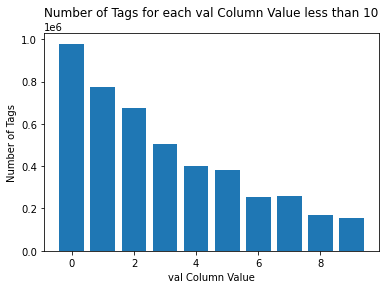

In [2]:
def execute_sql_query(query):
    dbfile = "lastfm.db"
    if not os.path.isfile(dbfile):
        print('ERROR: db file %s does not exist?' % dbfile)

    con = sqlite3.connect(dbfile)
    cur = con.cursor()
    cur.execute(query)
    data = cur.fetchall()
    con.close()
    return data

val_query = (
    "SELECT val, COUNT(*) "
    "FROM tid_tag "
    "WHERE val < 10 "
    "GROUP BY val"
)

val_data = execute_sql_query(val_query)
val_values = np.array([x[0] for x in val_data])
val_count = np.array([x[1] for x in val_data])
plt.bar(np.arange(int(min(val_values)), int(max(val_values)) + 1), val_count)
plt.xlabel("val Column Value")
plt.ylabel("Number of Tags")
plt.title("Number of Tags for each val Column Value less than 10", y=1.05)
plt.show()

As we can see, there are almost 1 million tags that have the value 0 along with hundreds of thousands of tags that also have relatively small values. I would imagine that the top tags for a track would not have a count of 0. Even if the track had no tags, then it would be more reasonable for the last.fm API to return an empty result instead of a tag with count 0. Thus, it seems unlikely that the `val` column refers to the `count` field from the sample response from `track.getTopTags`.

However, there still may be a relationship between a tag's popularity and the value associated with the track. We will quantify a tag's popularity using the number of tracks that contain the tag. We first take a look at the distribution of the number of tracks that contain a certain tag.

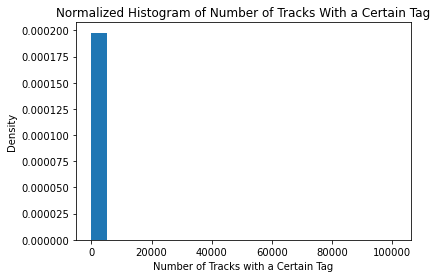

In [3]:
count_query = (
    "SELECT COUNT(*) "
    "FROM tags, tid_tag, tids "
    "WHERE tags.tag_id = tid_tag.tag AND "
    "tids.tid_id = tid_tag.tid "
    "GROUP BY tags.tag"
)

count_raw_data = execute_sql_query(count_query)
count = np.array([x[0] for x in count_raw_data])
plt.hist(count, bins=20, density = True)
plt.xlabel("Number of Tracks with a Certain Tag")
plt.ylabel("Density")
plt.title("Normalized Histogram of Number of Tracks With a Certain Tag")
plt.show()

This histogram seems to suggest that most tags do not have many tracks tagged with the corresponding tag. For instance, we can take a look at some tags that only have one track tagged.

In [4]:
low_count_query = (
    "SELECT tags.tag "
    "FROM tags, tid_tag, tids "
    "WHERE tags.tag_id = tid_tag.tag AND "
    "tids.tid_id = tid_tag.tid "
    "GROUP BY tags.tag "
    "HAVING COUNT(tids.tid) = 1 "
    "LIMIT 5"
)

low_count_raw_data = execute_sql_query(low_count_query)
for tag in low_count_raw_data:
    print(tag[0])

#4
'77 punk
*nsync
-  02-6769613
-  Reject All American


We now display the more popular tags.

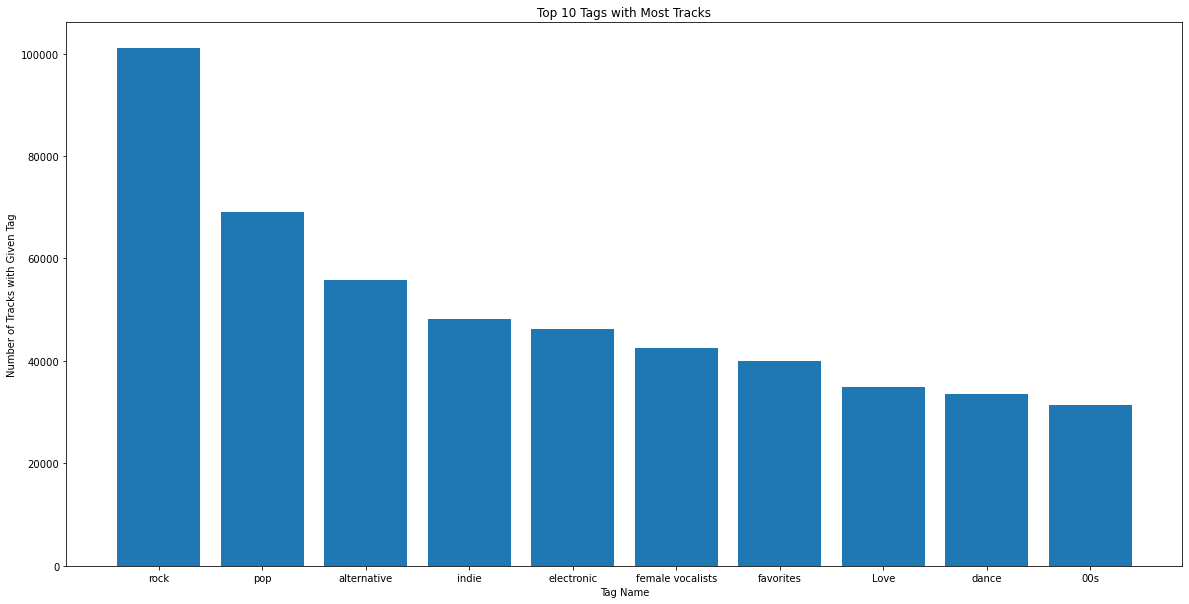

In [5]:
high_count_query = (
    "SELECT tags.tag, COUNT(tids.tid)"
    "FROM tags, tid_tag, tids "
    "WHERE tags.tag_id = tid_tag.tag AND "
    "tids.tid_id = tid_tag.tid "
    "GROUP BY tags.tag "
    "ORDER BY COUNT(tids.tid) DESC "
    "LIMIT 10"
)

high_count_data = execute_sql_query(high_count_query)
high_count_tags = np.array([x[0] for x in high_count_data])
high_count_tags_count = np.array([x[1] for x in high_count_data])
plt.figure(figsize=(20, 10))
plt.bar(high_count_tags, high_count_tags_count)
plt.xlabel("Tag Name")
plt.ylabel("Number of Tracks with Given Tag")
plt.title("Top 10 Tags with Most Tracks")
plt.show()

As we can see, the tags that are tagged by more tracks are the tags that are more likely to be displayed on the last.fm website for a given track. In other words, we are more likely to find a track tagged with "rock" instead of "#4" on last.fm. To help with our analysis, we will omit any tags with less than 10000 associated tracks. We now display the updated histogram from before.

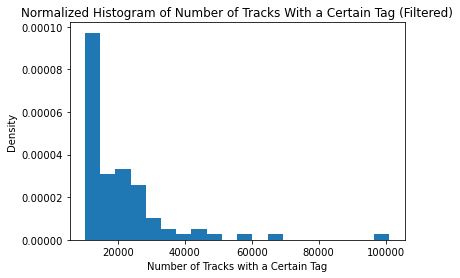

In [6]:
filtered_count = np.array([x[0] for x in count_raw_data if x[0] > 10000])
plt.hist(filtered_count, bins=20, density = True)
plt.xlabel("Number of Tracks with a Certain Tag")
plt.ylabel("Density")
plt.title("Normalized Histogram of Number of Tracks With a Certain Tag (Filtered)")
plt.show()

This histogram looks much better than before. We still observe that there is a right skew, but it is acceptable enough for us to do some rudimentary analysis.

We now plot the average `val` for each tag against the number of tracks with the given tag.

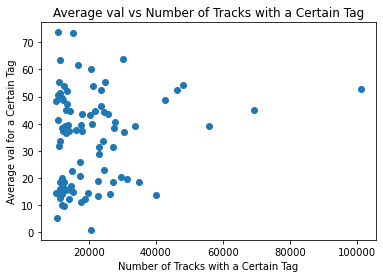

In [7]:
count_with_val_query = (
    "SELECT COUNT(*), AVG(VAL)"
    "FROM tags, tid_tag, tids "
    "WHERE tags.tag_id = tid_tag.tag AND "
    "tids.tid_id = tid_tag.tid "
    "GROUP BY tags.tag "
    "HAVING COUNT(*) > 10000"
)

count_with_val_raw_data = execute_sql_query(count_with_val_query)
count = np.array([x[0] for x in count_with_val_raw_data])
avg_val = np.array([x[1] for x in count_with_val_raw_data])
plt.scatter(count, avg_val)
plt.xlabel("Number of Tracks with a Certain Tag")
plt.ylabel("Average val for a Certain Tag")
plt.title("Average val vs Number of Tracks with a Certain Tag")
plt.show()

We see that there is a weak positive trend where a tag with more associated tracks will have a higher average `val` value. We examine the correlation coefficient for further evidence.

In [8]:
lr = scipy.stats.linregress(count, avg_val)
lr.rvalue

0.16168519749804955

Barring any mention of correlation does not imply causation, a correlation coefficient of 0.16 is also too weak for any meaningful discussion. As a result, we cannot say that there is any significant relationship between the popularity of a tag and the average `val` of a tag.

## Final Thoughts

Please document your datasets. Then again, this analysis would not have been as interesting if the dataset was properly documented. I also realize that I could have probably joined the [MSD mailing list](https://groups.google.com/g/millionsongdataset?pli=1), but again what is the fun in that?